In [7]:
from sklearn.decomposition import PCA
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict, defaultdict
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ========================== 数据加载 ==========================
DATA_PATH = '房价'

def load_data():
    """加载训练集和测试集"""
    train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
    test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
    return train_data, test_data

train_data, test_data = load_data()
train_target = train_data["SalePrice"]
train_data = train_data.drop(columns=["Id", "SalePrice"])


# 修改后的preprocess_data函数
def preprocess_data(train_data, test_data):
    """数据预处理（标准化、缺失值填充、独热编码）"""
    all_features = pd.concat([train_data, test_data.iloc[:, 1:]])
    
    # 处理数值型特征
    numerical_features = all_features.select_dtypes(exclude="object").columns
    all_features[numerical_features] = all_features[numerical_features].fillna(0)
    
    # 计算均值和标准差
    mean = all_features[numerical_features].mean()
    std = all_features[numerical_features].std()
    
    # 标准化
    all_features[numerical_features] = (all_features[numerical_features] - mean) / std
    
    # 处理分类变量（独热编码）
    all_features = pd.get_dummies(all_features, dummy_na=True)
    all_features = all_features.astype(float)

    return all_features, mean, std  # 返回处理后的数据和统计量



# 修改数据预处理部分
all_features, mean, std = preprocess_data(train_data, test_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 转换为 PyTorch 张量
trainset = torch.tensor(all_features[:1460].values, dtype=torch.float32).to(device)
# traintarget = torch.tensor(np.log1p(train_target.values), dtype=torch.float32).to(device)  # 对Y做对数变换
traintarget = torch.tensor(train_target.values, dtype=torch.float32).to(device)  


class ParametricGELU(nn.Module):
    def __init__(self, sigma=0.15):
        super(ParametricGELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma))

    def forward(self, x):
        return 0.5 * x * (1 + torch.erf(x / (torch.sqrt(torch.tensor(2.0)) * self.sigma)))

class HousePriceNet(nn.Module):
    def __init__(self):
        super(HousePriceNet, self).__init__()
        self.fc1 = nn.Linear(330, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1)
        self.gelu = ParametricGELU(sigma=0.15)
        self._initialize_weights()

    def _initialize_weights(self):
        """Xavier 初始化权重"""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        activations = []
        x = self.fc1(x)
        x = self.gelu(x)
        activations.append(x.clone())
        
        x = self.fc2(x)
        x = self.gelu(x)
        activations.append(x.clone())
        
        x = self.fc3(x)
        x = self.gelu(x)
        activations.append(x.clone())
        
        x = self.fc4(x)
        activations.append(x.clone())
        return x, activations

def msle_loss(pred, target):
    """统一的均方对数误差（MSLE）实现"""
    # 确保对输入进行相同的对数变换
    log_pred = torch.log(pred + 1)
    log_target = torch.log(target + 1)
    return nn.MSELoss()(log_pred, log_target)

import math
from scipy.special import gammaln

class MI_Calculator:
    """改进的互信息计算器，解决高维溢出问题"""
    def __init__(self, k=100, max_dim=50):
        """
        k: k近邻方法中的邻居数
        max_dim: 最大支持维度，超过此维度将使用PCA降维
        """
        self.k = k
        self.max_dim = max_dim
        
    def _reduce_dimension(self, X):
        """如果维度太高，使用PCA降维"""
        if X.shape[1] > self.max_dim:
            pca = PCA(n_components=self.max_dim)
            return pca.fit_transform(X)
        return X
        
    def _entropy(self, X):
        """基于k近邻的熵估计 (Kraskov方法)，解决高维问题"""
        X = self._reduce_dimension(X)
        n_samples, dimension = X.shape
        
        if n_samples == 0:
            return 0.0
            
        # 计算每个点到其k近邻的距离
        nn = NearestNeighbors(n_neighbors=self.k+1)
        nn.fit(X)
        distances, _ = nn.kneighbors(X)
        max_distances = distances[:, -1]
        
        # 使用对数空间计算单位球体积，避免数值溢出
        log_volume = (dimension/2) * math.log(math.pi) - gammaln(dimension/2 + 1)
        
        # 计算熵（对数空间）
        entropy = (dimension * np.mean(np.log(max_distances + np.finfo(float).eps)) + 
                  log_volume + math.log(n_samples) - np.euler_gamma)
        
        return entropy
    
    def mutual_information(self, X, Y):
        """
        计算X和Y之间的互信息
        使用Kraskov的k近邻方法，解决高维问题
        """
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
            
        # 联合熵H(X,Y)
        XY = np.hstack((X, Y))
        H_XY = self._entropy(XY)
        
        # 边际熵H(X)和H(Y)
        H_X = self._entropy(X)
        H_Y = self._entropy(Y)
        
        # 互信息I(X;Y) = H(X) + H(Y) - H(X,Y)
        return max(0, H_X + H_Y - H_XY)  # 确保非负
    


class MI_Plate:
    def __init__(self, model):
        self.model = model
        self.n_epochs = 3500
        self.mi_calculator = MI_Calculator(k=100)
        
    def save_activations(self, trainset, traintarget, epochs=3500, lr=1e-3, weight_decay=1e-3):
        """保存训练过程中的激活值"""
        if not os.path.exists('activations'):
            os.makedirs('activations')
            
        train_dataset = TensorDataset(trainset, traintarget)
        full_train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses = [] 
        for epoch in tqdm(range(epochs), desc="Training"):
            self.model.train()
            pred, _ = self.model(trainset)
            loss = msle_loss(pred.squeeze(), traintarget)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch % 500 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
            
            self.model.eval()
            with torch.no_grad():
                for data, labels in full_train_loader:
                    _, activations = self.model(data)
                    Y = labels.cpu().numpy()
                    
                    save_flag = False
                    if epoch < 20:
                        save_flag = True
                    elif (epoch < 100) and (epoch % 5 == 0):
                        save_flag = True
                    elif (epoch < 200) and (epoch % 10 == 0):
                        save_flag = True
                    elif (epoch % 100 == 0):
                        save_flag = True
                    
                    if save_flag:
                        fname = f"activations/epoch{epoch:08d}"
                        with open(fname, 'wb') as f:
                            pickle.dump([activations, Y, epoch], f, pickle.HIGHEST_PROTOCOL)
        np.save('train_lossesG1.npy', np.array(train_losses))  # 保存为二进制文件
    def compute_MI(self, subsample=1000):
        """使用改进的k近邻方法计算互信息"""
        activations_dir = 'activations'
        if not os.path.exists(activations_dir):
            raise FileNotFoundError(f"Directory {activations_dir} not found")
        
        measures = OrderedDict()
        measures['KNN'] = defaultdict(dict)
    
        MI_XM_array = []
        MI_YM_array = []
    
        for epochfile in tqdm(sorted(os.listdir(activations_dir)), desc="Computing MI"):
            if not epochfile.startswith('epoch'):
                continue
    
            with open(os.path.join(activations_dir, epochfile), 'rb') as f:
                activations, Y, epoch = pickle.load(f)
            
            layer_activations = [act.cpu().numpy() for act in activations]
            X = activations[0].cpu().numpy()  # 输入特征
            
            # 随机子采样以减少计算量
            if subsample and len(Y) > subsample:
                idx = np.random.choice(len(Y), subsample, replace=False)
                Y = Y[idx]
                X = X[idx]
                layer_activations = [layer[idx] for layer in layer_activations]
            
            cepochdata = defaultdict(list)
            for lndx, activity in enumerate(layer_activations):
                # 计算I(X;M) - 输入与中间表示的互信息
                MI_XM = self.mi_calculator.mutual_information(X, activity)
                
                # 计算I(Y;M) - 输出与中间表示的互信息
                MI_YM = self.mi_calculator.mutual_information(Y.reshape(-1,1), activity)
                
                cepochdata['MI_XM'].append(MI_XM)
                cepochdata['MI_YM'].append(MI_YM)
    
            measures['KNN'][epoch] = cepochdata
            MI_XM_array.append(cepochdata['MI_XM'])
            MI_YM_array.append(cepochdata['MI_YM'])
    
        # 保存结果
        np.save('MI_XM_knnG1.npy', np.array(MI_XM_array))
        np.save('MI_YM_knnG1.npy', np.array(MI_YM_array))
    
        with open('MI_results_knnG1.pkl', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)
    
        return measures

# 初始化模型
model = HousePriceNet().to(device)
    
# 初始化互信息计算器
mi_plate = MI_Plate(model)
    
# 训练并保存激活值
mi_plate.save_activations(trainset, traintarget)
    
# 计算互信息
mi_results = mi_plate.compute_MI()

Training:   0%|          | 1/3500 [00:00<09:11,  6.35it/s]

Epoch 0: Loss = 147.312851


Training:  14%|█▍        | 503/3500 [00:13<01:03, 47.54it/s]

Epoch 500: Loss = 0.038401


Training:  29%|██▊       | 1004/3500 [00:25<01:00, 41.31it/s]

Epoch 1000: Loss = 0.019956


Training:  43%|████▎     | 1508/3500 [00:36<00:44, 44.80it/s]

Epoch 1500: Loss = 0.015022


Training:  57%|█████▋    | 2008/3500 [00:47<00:31, 47.25it/s]

Epoch 2000: Loss = 0.012506


Training:  72%|███████▏  | 2507/3500 [00:59<00:21, 45.47it/s]

Epoch 2500: Loss = 0.011211


Training:  75%|███████▍  | 2618/3500 [01:01<00:20, 42.33it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]
    # 创建从数组索引到实际epoch的映射
    def get_actual_epoch(index):
        if index < 20:  # 前20个epoch每个都保存
            return index
        elif index < 100//5 + 20:  # 然后每5个epoch保存一次
            return 20 + (index - 20)*5
        elif index < (200-100)//10 + (100//5) + 20:  # 然后每10个epoch保存一次
            return 100 + (index - (100//5 + 20))*10
        else:  # 最后每100个epoch保存一次
            return 200 + (index - ((200-100)//10 + (100//5) + 20))*100

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 获取实际epoch
        actual_epoch = get_actual_epoch(i)
        
        # 直接使用实际epoch作为颜色索引
        color_idx = actual_epoch
           
        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    # ax.set_xticks([4, 6, 8, 10, 12, 14])
    # ax.set_yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.0 ,2.0)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.1, 0.98, '(c)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/FigBSDG1.eps', dpi=800)
    plt.show()

IXT_array = np.load('MI_XM_knnG1.npy',allow_pickle=True)
ITY_array = np.load('MI_YM_knnG1.npy',allow_pickle=True)


plot_information_plane(IXT_array, ITY_array, num_epochs=3500, every_n_early=1, every_n_late=5)

In [ ]:
import numpy as np

# 加载互信息数据文件
mi_xm = np.load('MI_XM_knnG1.npy')
mi_ym = np.load('MI_YM_knnG1.npy')

print(f"MI_XM shape: {mi_xm.shape}, 包含 {len(mi_xm)} 个值")
print(f"MI_YM shape: {mi_ym.shape}, 包含 {len(mi_ym)} 个值")
# print("\n前5个值示例:")
print("MI_XM",mi_xm)
print("MI_YM",mi_ym)

In [ ]:
from sklearn.decomposition import PCA
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict, defaultdict
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ========================== 数据加载 ==========================
DATA_PATH = '房价'

def load_data():
    """加载训练集和测试集"""
    train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
    test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
    return train_data, test_data

train_data, test_data = load_data()
train_target = train_data["SalePrice"]
train_data = train_data.drop(columns=["Id", "SalePrice"])


# 修改后的preprocess_data函数
def preprocess_data(train_data, test_data):
    """数据预处理（标准化、缺失值填充、独热编码）"""
    all_features = pd.concat([train_data, test_data.iloc[:, 1:]])
    
    # 处理数值型特征
    numerical_features = all_features.select_dtypes(exclude="object").columns
    all_features[numerical_features] = all_features[numerical_features].fillna(0)
    
    # 计算均值和标准差
    mean = all_features[numerical_features].mean()
    std = all_features[numerical_features].std()
    
    # 标准化
    all_features[numerical_features] = (all_features[numerical_features] - mean) / std
    
    # 处理分类变量（独热编码）
    all_features = pd.get_dummies(all_features, dummy_na=True)
    all_features = all_features.astype(float)

    return all_features, mean, std  # 返回处理后的数据和统计量



# 修改数据预处理部分
all_features, mean, std = preprocess_data(train_data, test_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 转换为 PyTorch 张量
trainset = torch.tensor(all_features[:1460].values, dtype=torch.float32).to(device)
# traintarget = torch.tensor(np.log1p(train_target.values), dtype=torch.float32).to(device)  # 对Y做对数变换
traintarget = torch.tensor(train_target.values, dtype=torch.float32).to(device)  


class ParametricGELU(nn.Module):
    def __init__(self, sigma=0.15):
        super(ParametricGELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma))

    def forward(self, x):
        return 0.5 * x * (1 + torch.erf(x / (torch.sqrt(torch.tensor(2.0)) * self.sigma)))

class HousePriceNet(nn.Module):
    def __init__(self):
        super(HousePriceNet, self).__init__()
        self.fc1 = nn.Linear(330, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1)
        self.gelu = ParametricGELU(sigma=0.15)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        """Xavier 初始化权重"""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        activations = []
        x = self.fc1(x)
        x = self.relu(x)
        activations.append(x.detach().clone())
        
        x = self.fc2(x)
        x = self.relu(x)
        activations.append(x.detach().clone())
        
        x = self.fc3(x)
        x = self.relu(x)
        activations.append(x.detach().clone())
        
        x = self.fc4(x)
        activations.append(x.detach().clone())
        return x, activations

def msle_loss(pred, target):
    """统一的均方对数误差（MSLE）实现"""
    # 确保对输入进行相同的对数变换
    log_pred = torch.log(pred + 1)
    log_target = torch.log(target + 1)
    return nn.MSELoss()(log_pred, log_target)

import math
from scipy.special import gammaln

class MI_Calculator:
    """改进的互信息计算器，解决高维溢出问题"""
    def __init__(self, k=100, max_dim=50):
        """
        k: k近邻方法中的邻居数
        max_dim: 最大支持维度，超过此维度将使用PCA降维
        """
        self.k = k
        self.max_dim = max_dim
        
    def _reduce_dimension(self, X):
        """如果维度太高，使用PCA降维"""
        if X.shape[1] > self.max_dim:
            pca = PCA(n_components=self.max_dim)
            return pca.fit_transform(X)
        return X
        
    def _entropy(self, X):
        """基于k近邻的熵估计 (Kraskov方法)，解决高维问题"""
        X = self._reduce_dimension(X)
        n_samples, dimension = X.shape
        
        if n_samples == 0:
            return 0.0
            
        # 计算每个点到其k近邻的距离
        nn = NearestNeighbors(n_neighbors=self.k+1)
        nn.fit(X)
        distances, _ = nn.kneighbors(X)
        max_distances = distances[:, -1]
        
        # 使用对数空间计算单位球体积，避免数值溢出
        log_volume = (dimension/2) * math.log(math.pi) - gammaln(dimension/2 + 1)
        
        # 计算熵（对数空间）
        entropy = (dimension * np.mean(np.log(max_distances + np.finfo(float).eps)) + 
                  log_volume + math.log(n_samples) - np.euler_gamma)
        
        return entropy
    
    def mutual_information(self, X, Y):
        """
        计算X和Y之间的互信息
        使用Kraskov的k近邻方法，解决高维问题
        """
        X = np.asarray(X)
        Y = np.asarray(Y)
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)
            
        # 联合熵H(X,Y)
        XY = np.hstack((X, Y))
        H_XY = self._entropy(XY)
        
        # 边际熵H(X)和H(Y)
        H_X = self._entropy(X)
        H_Y = self._entropy(Y)
        
        # 互信息I(X;Y) = H(X) + H(Y) - H(X,Y)
        return max(0, H_X + H_Y - H_XY)  # 确保非负
    


class MI_Plate:
    def __init__(self, model):
        self.model = model
        self.n_epochs = 3500
        self.mi_calculator = MI_Calculator(k=100)
        
    def save_activations(self, trainset, traintarget, epochs=3500, lr=1e-3, weight_decay=1e-3):
        """保存训练过程中的激活值"""
        if not os.path.exists('activations'):
            os.makedirs('activations')
            
        train_dataset = TensorDataset(trainset, traintarget)
        full_train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        train_losses = [] 
        for epoch in tqdm(range(epochs), desc="Training"):
            self.model.train()
            pred, _ = self.model(trainset)
            loss = msle_loss(pred.squeeze(), traintarget)
            train_losses.append(loss.item())  # 保存标量值
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch % 500 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
            
            self.model.eval()
            with torch.no_grad():
                for data, labels in full_train_loader:
                    _, activations = self.model(data)
                    Y = labels.cpu().numpy()
                    
                    save_flag = False
                    if epoch < 20:
                        save_flag = True
                    elif (epoch < 100) and (epoch % 5 == 0):
                        save_flag = True
                    elif (epoch < 200) and (epoch % 10 == 0):
                        save_flag = True
                    elif (epoch % 100 == 0):
                        save_flag = True
                    
                    if save_flag:
                        fname = f"activations/epoch{epoch:08d}"
                        with open(fname, 'wb') as f:
                            pickle.dump([activations, Y, epoch], f, pickle.HIGHEST_PROTOCOL)
        np.save('train_lossesR1.npy', np.array(train_losses))  # 保存为二进制文件
    def compute_MI(self, subsample=1000):
        """使用改进的k近邻方法计算互信息"""
        activations_dir = 'activations'
        if not os.path.exists(activations_dir):
            raise FileNotFoundError(f"Directory {activations_dir} not found")
        
        measures = OrderedDict()
        measures['KNN'] = defaultdict(dict)
    
        MI_XM_array = []
        MI_YM_array = []
    
        for epochfile in tqdm(sorted(os.listdir(activations_dir)), desc="Computing MI"):
            if not epochfile.startswith('epoch'):
                continue
    
            with open(os.path.join(activations_dir, epochfile), 'rb') as f:
                activations, Y, epoch = pickle.load(f)
            
            layer_activations = [act.cpu().numpy() for act in activations]
            X = activations[0].cpu().numpy()  # 输入特征
            
            # 随机子采样以减少计算量
            if subsample and len(Y) > subsample:
                idx = np.random.choice(len(Y), subsample, replace=False)
                Y = Y[idx]
                X = X[idx]
                layer_activations = [layer[idx] for layer in layer_activations]
            
            cepochdata = defaultdict(list)
            for lndx, activity in enumerate(layer_activations):
                # 计算I(X;M) - 输入与中间表示的互信息
                MI_XM = self.mi_calculator.mutual_information(X, activity)
                
                # 计算I(Y;M) - 输出与中间表示的互信息
                MI_YM = self.mi_calculator.mutual_information(Y.reshape(-1,1), activity)
                
                cepochdata['MI_XM'].append(MI_XM)
                cepochdata['MI_YM'].append(MI_YM)
    
            measures['KNN'][epoch] = cepochdata
            MI_XM_array.append(cepochdata['MI_XM'])
            MI_YM_array.append(cepochdata['MI_YM'])
    
        # 保存结果
        np.save('MI_XM_knnR1.npy', np.array(MI_XM_array))
        np.save('MI_YM_knnR1.npy', np.array(MI_YM_array))
    
        with open('MI_results_knnR1.pkl', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)
    
        return measures

# 初始化模型
model = HousePriceNet().to(device)
    
# 初始化互信息计算器
mi_plate = MI_Plate(model)
    
# 训练并保存激活值
mi_plate.save_activations(trainset, traintarget)
    
# 计算互信息
mi_results = mi_plate.compute_MI()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]
    # 创建从数组索引到实际epoch的映射
    def get_actual_epoch(index):
        if index < 20:  # 前20个epoch每个都保存
            return index
        elif index < 100//5 + 20:  # 然后每5个epoch保存一次
            return 20 + (index - 20)*5
        elif index < (200-100)//10 + (100//5) + 20:  # 然后每10个epoch保存一次
            return 100 + (index - (100//5 + 20))*10
        else:  # 最后每100个epoch保存一次
            return 200 + (index - ((200-100)//10 + (100//5) + 20))*100

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 获取实际epoch
        actual_epoch = get_actual_epoch(i)
        
        # 直接使用实际epoch作为颜色索引
        color_idx = actual_epoch
           
        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    # ax.set_xticks([4, 6, 8, 10, 12, 14])
    # ax.set_yticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
    # ax.set_ylim(0.0 ,2.0)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.1, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/FigBSDR1.eps', dpi=800)
    plt.show()

IXT_array = np.load('MI_XM_knnR1.npy',allow_pickle=True)
ITY_array = np.load('MI_YM_knnR1.npy',allow_pickle=True)


plot_information_plane(IXT_array, ITY_array, num_epochs=3500, every_n_early=1, every_n_late=5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


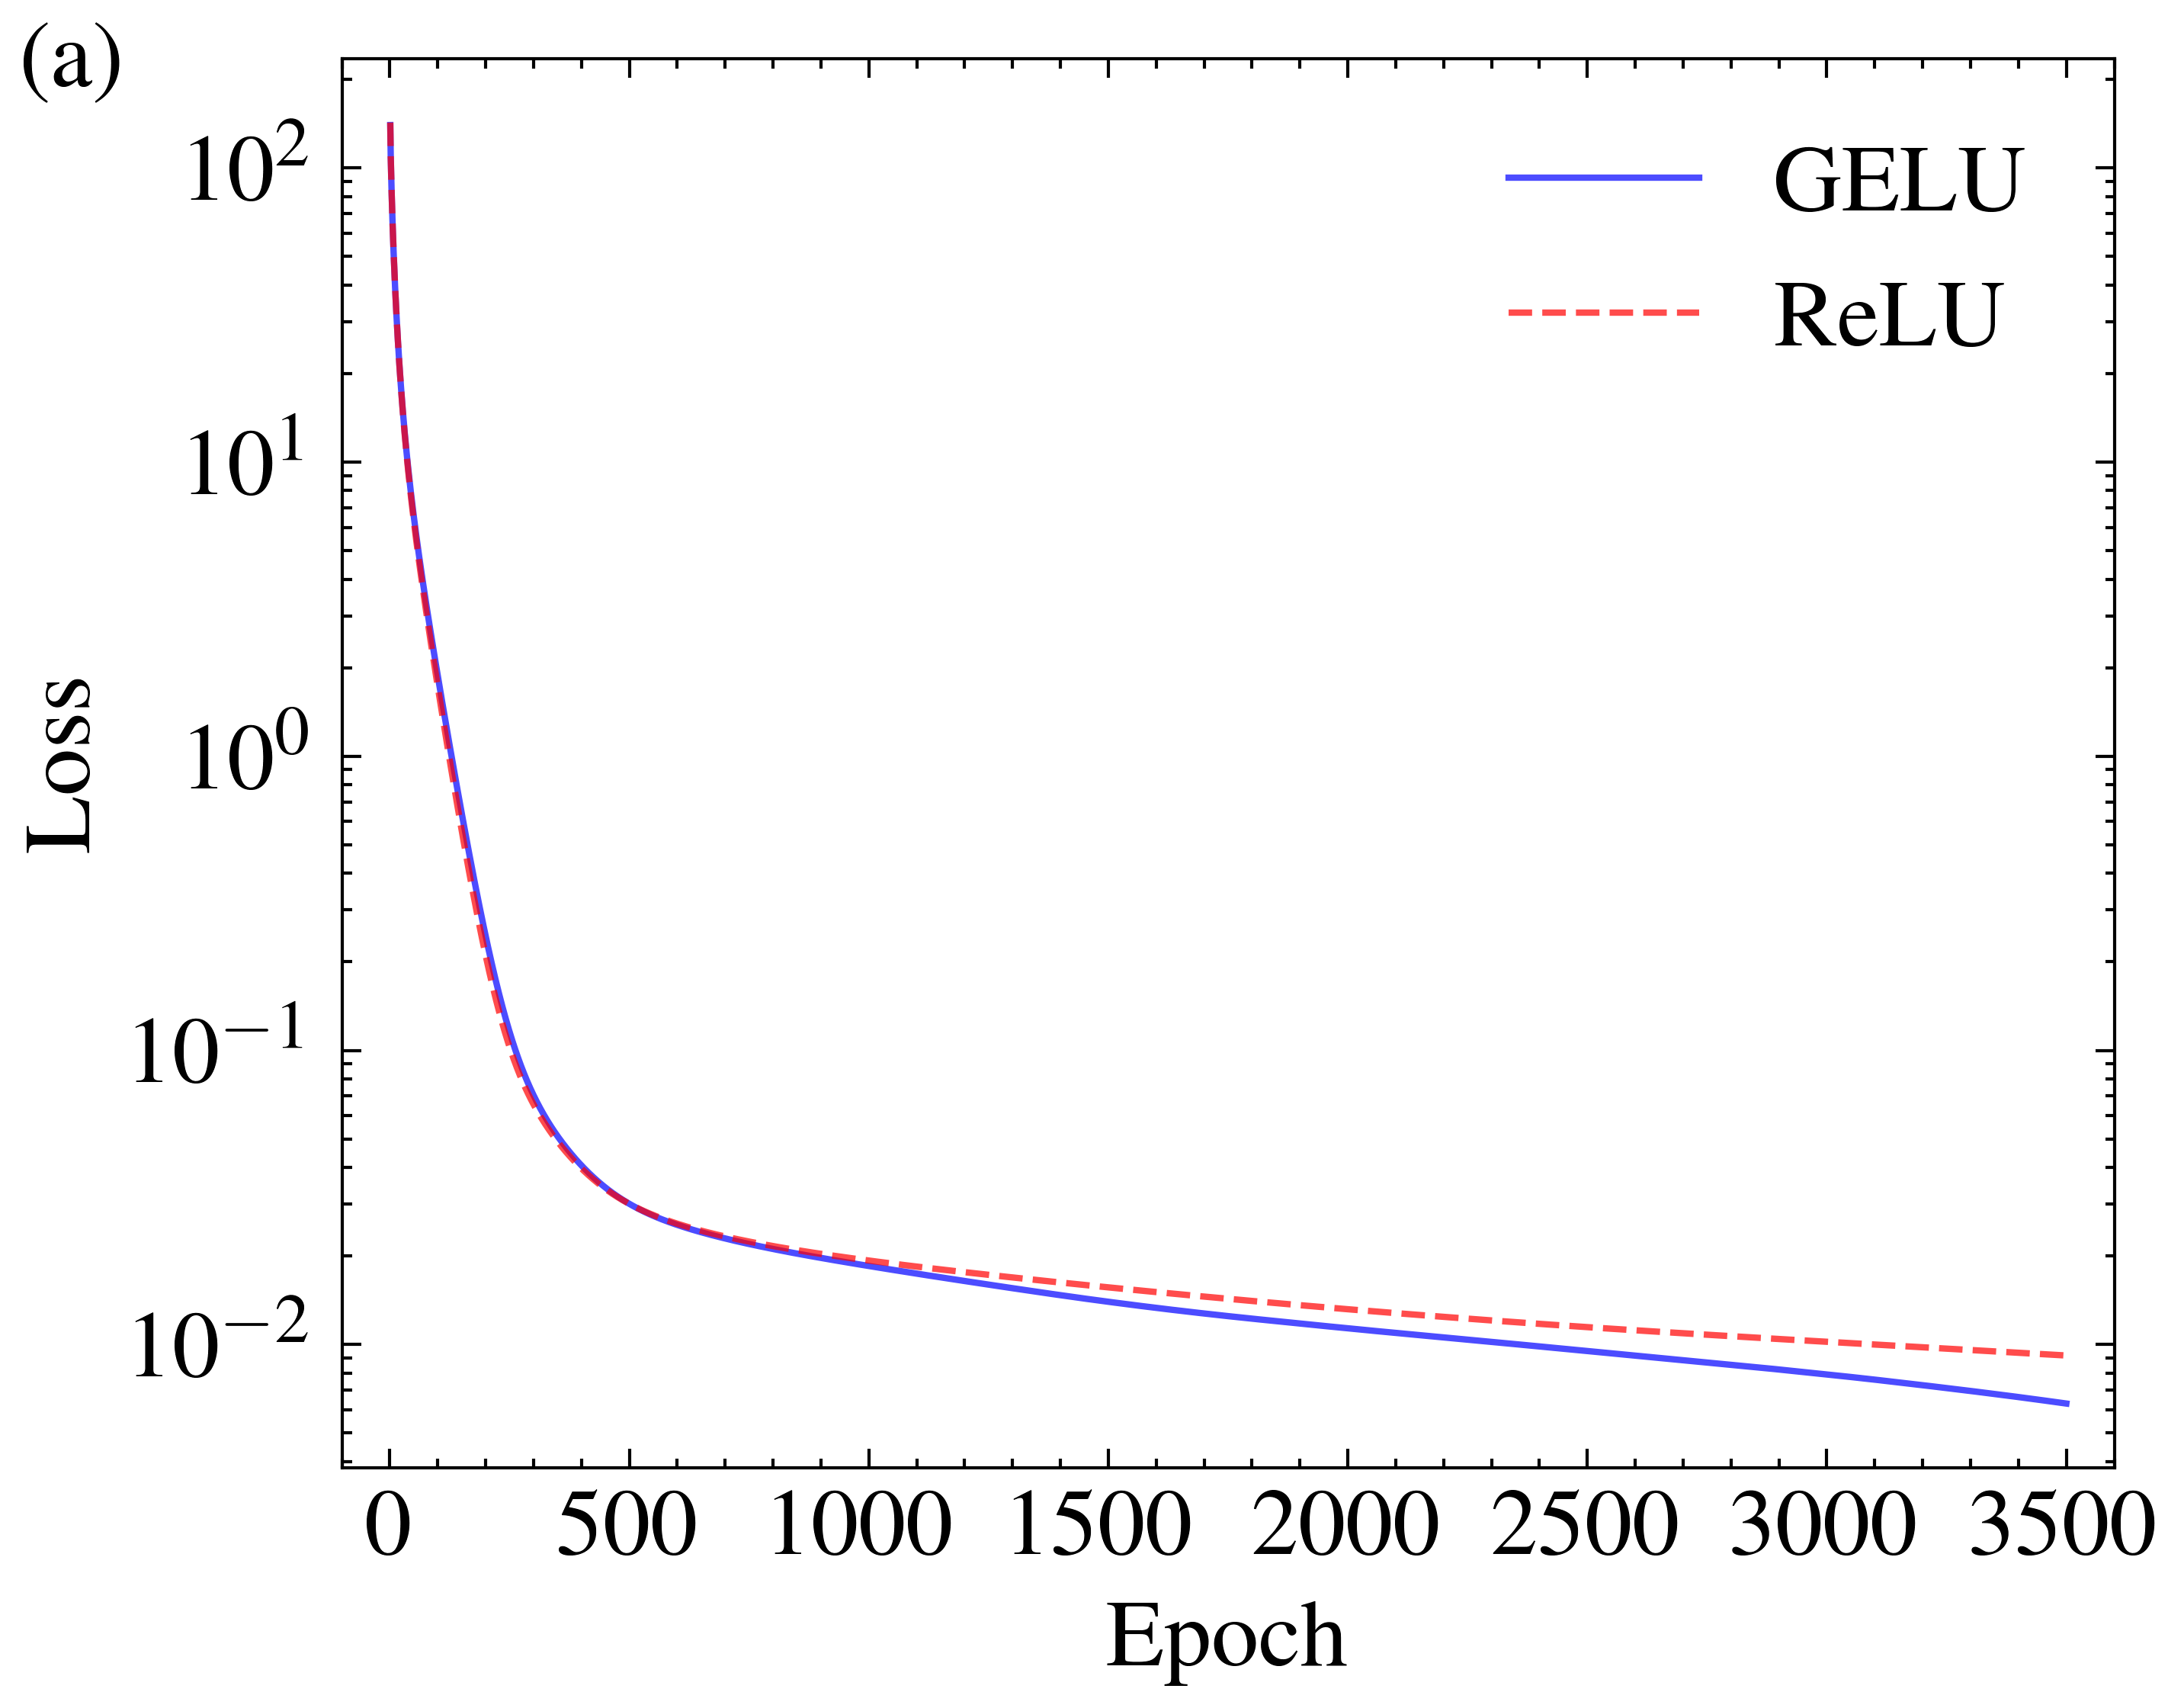

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

# 设置全局样式
plt.rcParams.update({
    'font.serif': ['Times New Roman'],
    'figure.dpi': 800,
    'axes.unicode_minus': False,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath, amssymb}'
})
plt.style.use(['science', 'ieee'])

# 1. 加载损失数据
lossesG = np.load('train_lossesG1.npy')  # 模型G的训练损失
lossesR = np.load('train_lossesR1.npy')  # 模型R的训练损失

# 2. 确保长度一致
min_length = min(len(lossesG), len(lossesR))
lossesG = lossesG[:min_length]
lossesR = lossesR[:min_length]

# 3. 创建横坐标
epochs = np.arange(1, min_length + 1)

# 4. 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 4))

# 5. 绘制原始损失曲线（不再取 log）
ax.plot(epochs, lossesG, label='GELU', color='blue', alpha=0.7)
ax.plot(epochs, lossesR, label='ReLU', color='red', alpha=0.7)

# 6. 设置 y 轴为对数刻度（以10为底）
ax.set_yscale('log')
ax.set_xticks(np.arange(0, 3501, 500))  # 每 500 个 epoch 一个刻度
ax.set_xlim(-100, 3600)  # 限定 x 轴显示范围

# 7. 添加图表元素
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel(r'$\mathrm{Loss}$', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

ax.legend(fontsize=15)
ax.text(-0.18, 0.98, '(a)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

# 8. 保存和显示
plt.savefig('log10_loss_comparison1.eps', dpi=800, bbox_inches='tight')
plt.show()
